# Testing on visible light camera images
The **MRL Eye Dataset** primarily consists of **infrared (IR)** camera images. These images have specific characteristics such as:
1. Minimal color information (grayscale or near-infrared tones)
2. Distinct contrast between iris, sclera, and eyelid regions
3. Reduced background clutter
4. Even illumination with less reflection and shadow

When a model trained on IR eye images is tested on visible-light camera images (RGB), its accuracy typically drops significantly. This happens because the visible-light images differ in:

1. Illumination conditions (shadows, glare, reflections)
2. Color variations (skin tone, lighting hue, etc.)
3. Texture and noise patterns


In [38]:
#imports
import os
import numpy as np
import torch
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import MobileNet_V2_Weights
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import mediapipe as mp
import itertools
from tqdm import tqdm #for progress bar


In [39]:
#model loading
model_path = 'models/eye_detector_mobilenetv2_(MRL_dataset).pth'

#recreated the same architecture
model = models.mobilenet_v2(weights=None)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)   # 2 classes: open / closed
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#load checkpoint
checkpoint = torch.load(model_path, map_location=device, weights_only=False)


#restore weights
model.load_state_dict(checkpoint['model_state_dict'])

#restore label mapping
idx_to_class = {v: k for k, v in checkpoint['class_to_idx'].items()}

#move model to device and set to eval mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()
#image transformer
transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

print("Model loaded successfully!")
print("Class labels:", idx_to_class)


Model loaded successfully!
Class labels: {0: 'close eyes', 1: 'open eyes'}


In [40]:
def predict_image(img_pil, model, transform, device, idx_to_class):
    model.eval()
    x = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        prob = torch.softmax(out, dim=1)
        pred = prob.argmax(dim=1).item()
        conf = prob.max().item()
    return idx_to_class[pred], conf

Overall accuracy: 0.9739

Per-class classification report:
               precision    recall  f1-score   support

   open eyes       0.95      1.00      0.97      1566
  close eyes       1.00      0.95      0.97      1657

    accuracy                           0.97      3223
   macro avg       0.97      0.97      0.97      3223
weighted avg       0.98      0.97      0.97      3223

Mean confidence (correct): 0.9826
Mean confidence (incorrect): 0.7660

Average predicted confidence per predicted class:
  open eyes: 0.9665
  close eyes: 0.9869


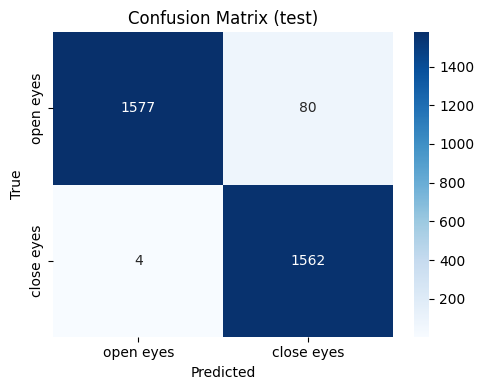


Summary table:


C:\Users\abhis\AppData\Local\Temp\ipykernel_31092\2928552593.py:101: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary.loc['overall'] = ['overall', None, None, None, len(y_true)]


,class,precision,recall,f1,support
0,open eyes,0.997470,0.951720,0.974058,1657
1,close eyes,0.951279,0.997446,0.973815,1566
overall,overall,NaN,NaN,NaN,3223



Examples count with conf < 0.6 and incorrect: 20


In [41]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import pandas as pd
import seaborn as sns

#Performance report on MRL dataset (test split)

mrl_root = "data/MRL_Eye_Dataset"
test_map = {
    'open eyes': os.path.join(mrl_root, "test", "open eyes"),
    'close eyes': os.path.join(mrl_root, "test", "close eyes"),
}
classes = list(test_map.keys())

#invert idx_to_class to get class->idx
class_to_idx = {v: k for k, v in idx_to_class.items()}

y_true = []
y_pred = []
y_conf = []  #confidence of predicted class
y_prob_open = []  #probability for 'open eyes' (for possible ROC/AUC later)

for cls in classes:
    folder = test_map[cls]
    if not os.path.isdir(folder):
        print(f"Missing folder: {folder}")
        continue
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith(valid_exts):
            continue
        fp = os.path.join(folder, fname)
        try:
            img_pil = Image.open(fp).convert('RGB')
        except Exception:
            continue

        #get model outputs (vector) to compute predicted label and confidences
        x = transformer(img_pil).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(x)
            probs = torch.softmax(out, dim=1).cpu().numpy().squeeze()

        pred_idx = int(probs.argmax())
        pred_label = idx_to_class[pred_idx]
        conf = float(probs.max())

        y_true.append(class_to_idx[cls])
        y_pred.append(pred_idx)
        y_conf.append(conf)
        #store prob for 'open eyes' (if class not present, use 0)
        y_prob_open.append(float(probs[class_to_idx.get('open eyes', 0)]) if 'open eyes' in class_to_idx else 0.0)

#basic metrics
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=[class_to_idx[c] for c in classes], zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=[class_to_idx[c] for c in classes])

print(f"Overall accuracy: {acc:.4f}")
report = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print("\nPer-class classification report:\n", report)

#average confidences for correct vs incorrect
confs = pd.DataFrame({
    'true': y_true,
    'pred': y_pred,
    'conf': y_conf
})
confs['correct'] = confs['true'] == confs['pred']
mean_conf_correct = confs.loc[confs['correct'], 'conf'].mean() if not confs.loc[confs['correct']].empty else float('nan')
mean_conf_incorrect = confs.loc[~confs['correct'], 'conf'].mean() if not confs.loc[~confs['correct']].empty else float('nan')

print(f"Mean confidence (correct): {mean_conf_correct:.4f}")
print(f"Mean confidence (incorrect): {mean_conf_incorrect:.4f}")

#per-class average confidence (predictions where model predicted that class)
per_class_conf = {}
for c in classes:
    idx = class_to_idx[c]
    sel = confs[confs['pred'] == idx]
    per_class_conf[c] = sel['conf'].mean() if not sel.empty else float('nan')
print("\nAverage predicted confidence per predicted class:")
for c, v in per_class_conf.items():
    print(f"  {c}: {v:.4f}")

#confusion matrix plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (test)')
plt.tight_layout()
plt.show()

#Save summary to DataFrame for easy inspection/export
summary = pd.DataFrame({
    'class': classes,
    'precision': prec,
    'recall': rec,
    'f1': f1,
    'support': sup
})
summary.loc['overall'] = ['overall', None, None, None, len(y_true)]
print("\nSummary table:")
display(summary)

#low-confidence incorrect examples from test set
low_thresh = 0.6
idxs_low_incorrect = confs[(confs['conf'] < low_thresh) & (~confs['correct'])].index.tolist()
if idxs_low_incorrect:
    print(f"\nExamples count with conf < {low_thresh} and incorrect: {len(idxs_low_incorrect)}")
else:
    print(f"\nNo incorrect test predictions with conf < {low_thresh}")


In [31]:
#finding image size of dataset image
def get_image_size(img_path):
    if not os.path.exists(img_path):
        raise FileNotFoundError(f"No such file: {img_path}")
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"Unable to read image (cv2.imread returned None): {img_path}")

    h, w = img.shape[:2]

    return {
        "width": w,
        "height": h
    }
ref_img_path = "data/MRL_Eye_Dataset/test/open eyes/s0001_01842_0_0_1_0_0_01.png"#path to an image in MRL Eye Dataset
info = get_image_size(ref_img_path)#path to an image in MRL Eye Dataset
print(info)

{'width': 82, 'height': 82}


## Extracting Eye Region from a Image
MRL-style eye extraction using Mediapipe iris landmarks

In [32]:
IMAGE_FOLDER = "local_images" #local clicked images folder
OUTPUT_DIR = "local_image_eye_crops"
SCALE = 4  #how large the square is relative to iris diameter

os.makedirs(OUTPUT_DIR, exist_ok=True)

#FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=10,
    min_detection_confidence=0.5
)

#Iris landmarks taken from MediaPipe FaceMesh
LEFT_IRIS = [474, 475, 476, 477]
RIGHT_IRIS = [469, 470, 471, 472]

#case handle if there are multiple faces in an image
total_eye_counter = 0
img_id = 0

for img_name in os.listdir(IMAGE_FOLDER):
    IMAGE_PATH = os.path.join(IMAGE_FOLDER, img_name)
    img = cv2.imread(IMAGE_PATH)
    
    if img is None:
        print(f"Cannot load image: {IMAGE_PATH}")
        continue
    
    h, w, _ = img.shape #height, width, channels
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb)

    if not results.multi_face_landmarks:
        print(f"No faces detected in {img_name}")
        continue

    #process each face detected
    for face_id, face_landmarks in enumerate(results.multi_face_landmarks, start=1):
        landmarks = face_landmarks.landmark

        def get_iris_center_and_radius(iris_indices):
            pts = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in iris_indices])
            (cx, cy), radius = cv2.minEnclosingCircle(pts)
            return int(cx), int(cy), int(radius)

        #left eye
        lx, ly, lr = get_iris_center_and_radius(LEFT_IRIS)
        left_size = int(lr * SCALE)
        lx1, ly1 = max(lx - left_size, 0), max(ly - left_size, 0)
        lx2, ly2 = min(lx + left_size, w), min(ly + left_size, h)
        left_eye_crop = img[ly1:ly2, lx1:lx2]

        left_eye_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_person{face_id}_left_eye_{img_id}.png")
        cv2.imwrite(left_eye_path, left_eye_crop)

        #right eye
        rx, ry, rr = get_iris_center_and_radius(RIGHT_IRIS)
        right_size = int(rr * SCALE)
        rx1, ry1 = max(rx - right_size, 0), max(ry - right_size, 0)
        rx2, ry2 = min(rx + right_size, w), min(ry + right_size, h)
        right_eye_crop = img[ry1:ry2, rx1:rx2]

        right_eye_path = os.path.join(OUTPUT_DIR, f"{os.path.splitext(img_name)[0]}_person{face_id}_right_eye_{img_id}.png")
        cv2.imwrite(right_eye_path, right_eye_crop)

        #visualization
        cv2.circle(img, (lx, ly), 3, (0, 255, 0), -1)
        cv2.circle(img, (rx, ry), 3, (0, 255, 0), -1)
        cv2.rectangle(img, (lx1, ly1), (lx2, ly2), (0, 255, 0), 2)
        cv2.rectangle(img, (rx1, ry1), (rx2, ry2), (0, 255, 0), 2)
        cv2.putText(img, f"P{face_id}", (lx1, ly1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        total_eye_counter += 2
        img_id += 1
print(f"\n Extracted {total_eye_counter} eye crops and saved inside '{OUTPUT_DIR}'.")
cv2.destroyAllWindows()



 Extracted 52 eye crops and saved inside 'local_image_eye_crops'.


## Extracting Global Mean Intensity andd Global Std

In [33]:



folder1 = r"data/MRL_Eye_Dataset/train/open eyes"
folder2 = r"data/MRL_Eye_Dataset/train/close eyes"
folder3 = r"data/MRL_Eye_Dataset/test/open eyes"
folder4 = r"data/MRL_Eye_Dataset/test/close eyes"

folders = [folder1, folder2, folder3, folder4]
valid_exts = (".jpg", ".jpeg", ".png")

#for each folder
def calculate_folder_mean(folder_path):
    means = []
    stds = []
    if not os.path.isdir(folder_path):
        print(f"skipping invalid folder: {folder_path}")
        return None

    print(f"\n processing folder: {os.path.basename(folder_path)}")

    for fname in tqdm(os.listdir(folder_path)):
        if not fname.lower().endswith(valid_exts):
            continue

        img_path = os.path.join(folder_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"could not read image: {img_path}")
            continue

        means.append(np.mean(img))
        stds.append(np.std(img))

    if not means:
        print(f"no images found in {folder_path}")
        return None

    folder_mean = np.mean(means)
    folder_std = np.mean(stds)
    print(f"mean pixel intensity for {os.path.basename(folder_path)}: {folder_mean:.2f}")
    print(f"std. deviation for {os.path.basename(folder_path)}: {folder_std:.2f}")
    return folder_mean, folder_std

#main loop
all_means = []
all_stds = []
folder_means = {}

for folder in folders:
    res = calculate_folder_mean(folder)
    if res is not None:
        mean_val, std_val = res
        folder_means[os.path.basename(folder)] = (mean_val, std_val)
        all_means.append(mean_val)
        all_stds.append(std_val)

#results
print("\n mean intensity summary")
for f, (m_mean, m_std) in folder_means.items():
    print(f"{f}: mean={m_mean:.2f}, std={m_std:.2f}")

if all_means:
    global_mean = np.mean(all_means)
    global_std = np.mean(all_stds)
    print(f"\n global mean intensity (all 4 folders): {global_mean:.2f}")
    print(f" global std. deviation (all 4 folders): {global_std:.2f}")
else:
    print(" no images found in any folder.")


 processing folder: open eyes


100%|██████████| 41295/41295 [00:13<00:00, 3061.40it/s]


mean pixel intensity for open eyes: 95.21
std. deviation for open eyes: 21.59

 processing folder: close eyes


100%|██████████| 40380/40380 [00:23<00:00, 1703.74it/s]


mean pixel intensity for close eyes: 82.16
std. deviation for close eyes: 16.02

 processing folder: open eyes


100%|██████████| 1657/1657 [00:01<00:00, 1466.85it/s]


mean pixel intensity for open eyes: 75.96
std. deviation for open eyes: 15.10

 processing folder: close eyes


100%|██████████| 1566/1566 [00:01<00:00, 1373.46it/s]

mean pixel intensity for close eyes: 78.83
std. deviation for close eyes: 9.25

 mean intensity summary
open eyes: mean=75.96, std=15.10
close eyes: mean=78.83, std=9.25

 global mean intensity (all 4 folders): 83.04
 global std. deviation (all 4 folders): 15.49


In [34]:
def preprocess_eye_image(
    img_path: str,#path to eye image
    output_size=(82, 82),#final output size
    gamma_value=0.6,#gamma correction value
    clip_limit=2.0,#CLAHE clip limit
    tile_size=(6, 6),#tile size for CLAHE
    noise_std=6,#noise standard deviation
    brightness_factor=1.1,#adjust overall brightness
    dark_boost_strength=0.5,#adjust boost for dark regions
    target_mean=global_mean,#global target mean
    target_std=global_std,#global target standard deviation
):
    #loadd image
    img = cv2.imread(img_path)
    if img is None:
        raise ValueError(f"cannot load image: {img_path}")

    #grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 5, 30, 30)  #preserves edges
    gray = cv2.equalizeHist(gray)  #global normalization

    #CLAHE for local contrast normalization
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_size)
    balanced = clahe.apply(gray)

    #gamma correction (to compress highlights)
    invGamma = 1.0 / gamma_value
    table = np.array([(i / 255.0) ** invGamma * 255 for i in np.arange(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(balanced, table)

    #soft smoothing (to remove harsh local contrast)
    smoothed = cv2.bilateralFilter(gamma_corrected, 3, 40, 40)

    #add subtle Gaussian noise
    noise = np.random.normal(0, noise_std, smoothed.shape)
    noisy = np.clip(smoothed.astype(np.float32) + noise, 0, 255).astype(np.uint8)

    #brighten darker regions selectively
    img_f = noisy.astype(np.float32)
    boost = dark_boost_strength * (1 - img_f / 255.0) * 70
    brightened = np.clip(img_f + boost, 0, 255)

    #global brightness boost
    brightened = np.clip(brightened * brightness_factor, 0, 255).astype(np.uint8)

    #normalize histogram to MRL mean/std
    mean, std = brightened.mean(), brightened.std()
    normalized = np.clip((brightened - mean) / (std + 1e-6) * target_std + target_mean, 0, 255).astype(np.uint8)

    #resize
    final_resized = cv2.resize(normalized, output_size, interpolation=cv2.INTER_AREA)

    return final_resized


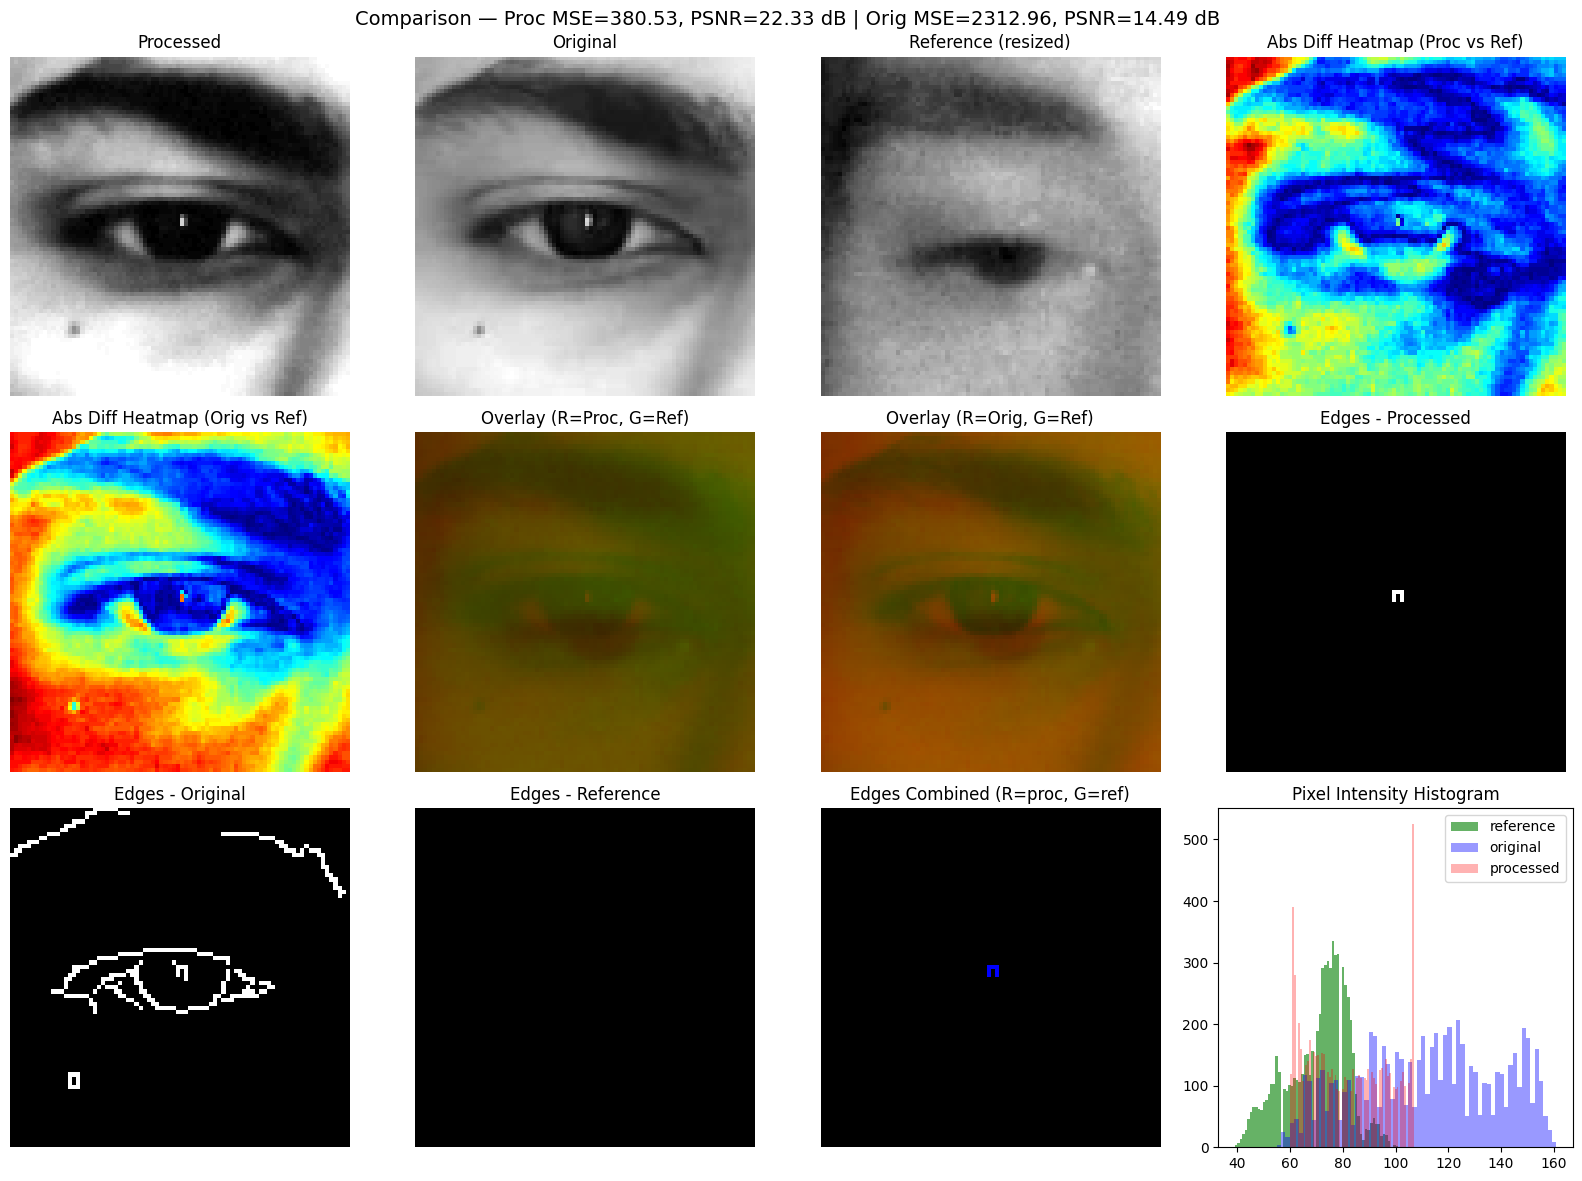

In [37]:
org_img_path = "local_image_eye_crops/image_2_person1_right_eye_10.png"
ref_img = cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE)
processed_img = preprocess_eye_image(org_img_path)
original_img = cv2.imread(org_img_path, cv2.IMREAD_GRAYSCALE)

#same as ref size
target_size = (82, 82)
ref_resized = cv2.resize(ref_img, target_size, interpolation=cv2.INTER_AREA)
original_resized = cv2.resize(original_img, target_size, interpolation=cv2.INTER_AREA)
processed_resized = cv2.resize(processed_img, target_size, interpolation=cv2.INTER_AREA)

#metrics: processed vs reference, original vs reference
mse_proc = np.mean((processed_resized.astype(np.float32) - ref_resized.astype(np.float32)) ** 2)
psnr_proc = cv2.PSNR(ref_resized, processed_resized)

mse_orig = np.mean((original_resized.astype(np.float32) - ref_resized.astype(np.float32)) ** 2)
psnr_orig = cv2.PSNR(ref_resized, original_resized)

#difference heatmaps
diff_proc = cv2.absdiff(processed_resized, ref_resized)
norm_diff_proc = cv2.normalize(diff_proc, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_proc = cv2.applyColorMap(norm_diff_proc, cv2.COLORMAP_JET)  #BGR

diff_orig = cv2.absdiff(original_resized, ref_resized)
norm_diff_orig = cv2.normalize(diff_orig, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
heatmap_orig = cv2.applyColorMap(norm_diff_orig, cv2.COLORMAP_JET)  #BGR

#overlays (red = processed/original, green = reference)
zeros = np.zeros_like(processed_resized, dtype=np.uint8)
overlay_proc = cv2.merge([zeros, ref_resized, processed_resized])   #BGR: (0, ref, proc)
overlay_orig = cv2.merge([zeros, ref_resized, original_resized])    #BGR: (0, ref, orig)

#edges
edges_ref = cv2.Canny(ref_resized, 50, 150)
edges_proc = cv2.Canny(processed_resized, 50, 150)
edges_orig = cv2.Canny(original_resized, 50, 150)
edges_combined_proc_ref = cv2.merge([edges_proc, edges_ref, np.zeros_like(edges_ref)])  #R=proc, G=ref
edges_combined_orig_ref = cv2.merge([edges_orig, edges_ref, np.zeros_like(edges_ref)])  #R=orig, G=ref

#plots
plt.figure(figsize=(16, 12))

plt.subplot(3, 4, 1)
plt.imshow(processed_resized, cmap='gray')
plt.title("Processed")
plt.axis('off')

plt.subplot(3, 4, 2)
plt.imshow(original_resized, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(3, 4, 3)
plt.imshow(ref_resized, cmap='gray')
plt.title("Reference (resized)")
plt.axis('off')

plt.subplot(3, 4, 4)
plt.imshow(cv2.cvtColor(heatmap_proc, cv2.COLOR_BGR2RGB))
plt.title("Abs Diff Heatmap (Proc vs Ref)")
plt.axis('off')

plt.subplot(3, 4, 5)
plt.imshow(cv2.cvtColor(heatmap_orig, cv2.COLOR_BGR2RGB))
plt.title("Abs Diff Heatmap (Orig vs Ref)")
plt.axis('off')

plt.subplot(3, 4, 6)
plt.imshow(cv2.cvtColor(overlay_proc, cv2.COLOR_BGR2RGB))
plt.title("Overlay (R=Proc, G=Ref)")
plt.axis('off')

plt.subplot(3, 4, 7)
plt.imshow(cv2.cvtColor(overlay_orig, cv2.COLOR_BGR2RGB))
plt.title("Overlay (R=Orig, G=Ref)")
plt.axis('off')

plt.subplot(3, 4, 8)
plt.imshow(edges_proc, cmap='gray')
plt.title("Edges - Processed")
plt.axis('off')

plt.subplot(3, 4, 9)
plt.imshow(edges_orig, cmap='gray')
plt.title("Edges - Original")
plt.axis('off')

plt.subplot(3, 4, 10)
plt.imshow(edges_ref, cmap='gray')
plt.title("Edges - Reference")
plt.axis('off')

plt.subplot(3, 4, 11)
plt.imshow(cv2.cvtColor(edges_combined_proc_ref, cv2.COLOR_BGR2RGB))
plt.title("Edges Combined (R=proc, G=ref)")
plt.axis('off')

plt.subplot(3, 4, 12)
plt.hist(ref_resized.ravel(), bins=64, color='g', alpha=0.6, label='reference')
plt.hist(original_resized.ravel(), bins=64, color='b', alpha=0.4, label='original')
plt.hist(processed_resized.ravel(), bins=64, color='r', alpha=0.3, label='processed')
plt.title("Pixel Intensity Histogram")
plt.legend()

plt.suptitle(f"Comparison — Proc MSE={mse_proc:.2f}, PSNR={psnr_proc:.2f} dB | Orig MSE={mse_orig:.2f}, PSNR={psnr_orig:.2f} dB", fontsize=14)
plt.tight_layout()
plt.show()


function to make a prediction for a given image,model,transformer,device,idx

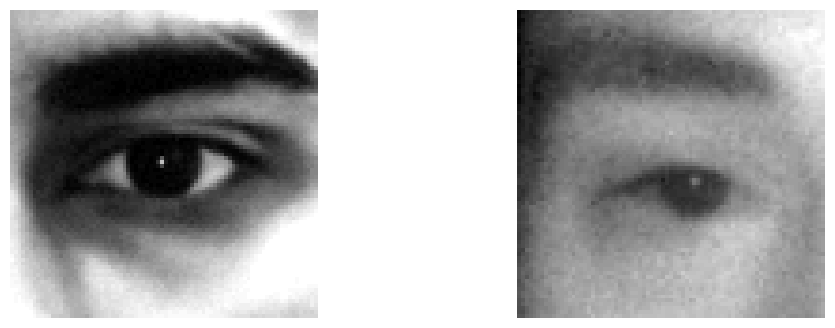

In [ ]:
#test on a sample image(using orginal image used in comparison)
preprocessed_img = preprocess_eye_image(org_img_path)
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.imshow(preprocessed_img, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.imread(ref_img_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.axis('off')

plt.show()

In [ ]:
#Test on a sample processed image
sample_preprocessed_img_pil = Image.fromarray(preprocessed_img).convert('RGB')
sample_img_pil = Image.open(org_img_path).convert('RGB')
test_img_pil = Image.open(org_img_path).convert('RGB')
sample_preprocessed_label, sample_preprocessed_conf = predict_image(sample_preprocessed_img_pil, model, transformer, device, idx_to_class) # prediciton class, confidence
sample_label, sample_conf = predict_image(sample_img_pil, model, transformer, device, idx_to_class)
test_label, test_conf = predict_image(test_img_pil, model, transformer, device, idx_to_class)
print('Orginal Image Prediction:', sample_label, sample_conf)
print('Processed Image Prediction:', sample_preprocessed_label, sample_preprocessed_conf)
print('Dataset Image Prediction:', test_label, test_conf)
print("Accuracy difference for Orginal and Processed image:", abs(sample_preprocessed_conf - sample_conf))

Orginal Image Prediction: open eyes 0.9966903924942017
Processed Image Prediction: open eyes 0.9996064305305481
Dataset Image Prediction: open eyes 0.9966903924942017
Accuracy difference for Orginal and Processed image: 0.0029160380363464355


## Now accuracy for all Local images taken

**We see a significant boost in confidance for local_images datset after preprocessing**

Predicting local images: 100%|██████████| 108/108 [00:02<00:00, 46.77it/s]


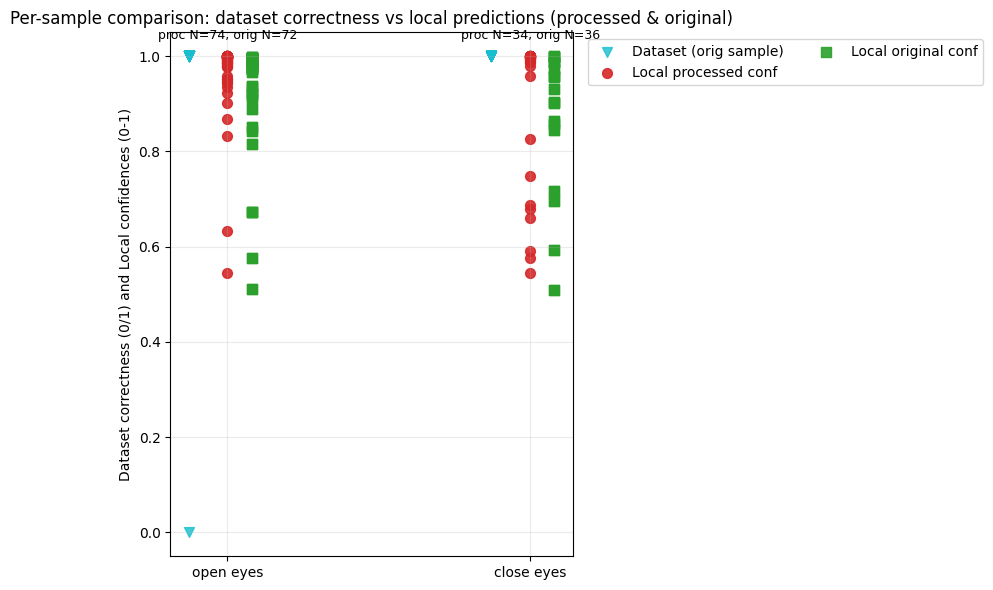

In [ ]:


# settings
local_dir = OUTPUT_DIR
test_folder_map = {
    'open eyes': folder3,
    'close eyes': folder4
}
classes = ['open eyes', 'close eyes']
valid_exts = ('.jpg', '.jpeg', '.png')

# accumulate per-image confidences
proc_confs = {c: [] for c in classes}
orig_confs = {c: [] for c in classes}

local_files = sorted([f for f in os.listdir(local_dir) if f.lower().endswith(valid_exts)])

for fname in tqdm(local_files, desc="Predicting local images"):
    path = os.path.join(local_dir, fname)

    # original prediction
    try:
        img_orig_pil = Image.open(path).convert('RGB')
        lab_o, conf_o = predict_image(img_orig_pil, model, transformer, device, idx_to_class)
        orig_confs[lab_o].append(conf_o)
    except Exception as e:
        # skip problematic files
        continue

    # processed prediction
    #ignore for dataset folders 
    if (fname != 'folder3') & (fname != 'folder4'):
        try:
            proc_np = preprocess_eye_image(path, target_mean=m_mean, target_std=m_std)
            proc_pil = Image.fromarray(proc_np).convert('RGB')
            lab_p, conf_p = predict_image(proc_pil, model, transformer, device, idx_to_class)
            proc_confs[lab_p].append(conf_p)
        except Exception:
            continue

#for each class: sample same-number test images and compute per-sample correctness (0/1)
np.random.seed(42)
dataset_correct_orig = {c: [] for c in classes}
results = {}

for cls in classes:
    test_folder = test_folder_map[cls]
    files = [f for f in os.listdir(test_folder) if f.lower().endswith(valid_exts)]

    N_proc = len(proc_confs[cls])
    N_orig = len(orig_confs[cls])

    #helper to sample and compute correctness list of length N
    def sample_correct_list(N):
        if N == 0:
            return []
        replace = len(files) < N
        sampled = list(np.random.choice(files, size=N, replace=replace))
        correct_list = []
        for sf in sampled:
            fp = os.path.join(test_folder, sf)
            try:
                pil = Image.open(fp).convert('RGB')
                pred_label, _ = predict_image(pil, model, transformer, device, idx_to_class)
                correct_list.append(1.0 if pred_label == cls else 0.0)
            except Exception:
                correct_list.append(0.0)
        return correct_list

    dataset_correct_orig[cls] = sample_correct_list(N_orig)

    results[cls] = {
        'N_proc': N_proc,
        'N_orig': N_orig,
        'dataset_correct_orig': dataset_correct_orig[cls],
        'local_proc_confs': proc_confs[cls],
        'local_orig_confs': orig_confs[cls]
    }

#plot per-sample scatter: dataset correctness (0/1), processed confidences, original confidences
x_map = {classes[0]: 0, classes[1]: 1}
plt.figure(figsize=(9,6))
jitter = 0.08

for cls in classes:
    x = x_map[cls]
    r = results[cls]
    #dataset points for orig-sample-size (cyan diamonds, slightly different marker/color to avoid confusion)
    y_ds_orig = r['dataset_correct_orig']
    if y_ds_orig:
        xs = [x - jitter*1.6] * len(y_ds_orig)
        plt.scatter(xs, y_ds_orig, color='tab:cyan', marker='v', s=50, alpha=0.8, label='Dataset (orig sample)' if cls==classes[0] else "")

    #processed local confidences (red circles)
    y_proc = r['local_proc_confs']
    if y_proc:
        xs = [x] * len(y_proc)
        plt.scatter(xs, y_proc, color='tab:red', marker='o', s=50, alpha=0.9, label='Local processed conf' if cls==classes[0] else "")

    #original local confidences (green squares)
    y_orig = r['local_orig_confs']
    if y_orig:
        xs = [x + jitter] * len(y_orig)
        plt.scatter(xs, y_orig, color='tab:green', marker='s', s=50, alpha=0.9, label='Local original conf' if cls==classes[0] else "")

    #annotate counts
    plt.text(x, 1.03, f"proc N={r['N_proc']}, orig N={r['N_orig']}", ha='center', va='bottom', fontsize=9)

plt.xticks([0,1], classes)
plt.ylim(-0.05, 1.05)
plt.ylabel("Dataset correctness (0/1) and Local confidences (0-1)")
plt.title("Per-sample comparison: dataset correctness vs local predictions (processed & original)")
plt.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(alpha=0.25)
plt.tight_layout()
plt.show()


Found 8 samples with confidence < 0.8. Showing up to 12 samples.


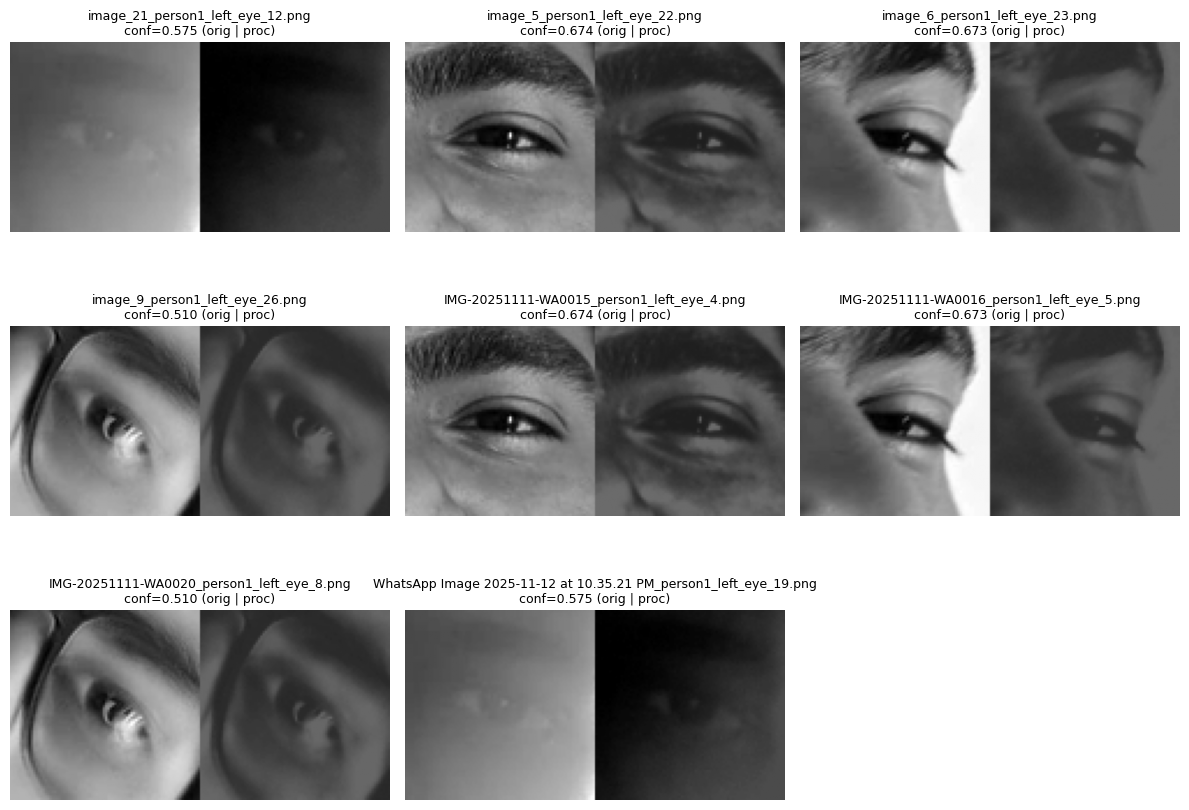

In [ ]:
#settings
threshold = 0.8
max_display = 12  # max samples to show

# filter
low_conf = [(fn, conf) for fn, conf in local_list if conf < threshold]
if not low_conf:
    print(f"No samples with confidence < {threshold}")
else:
    print(f"Found {len(low_conf)} samples with confidence < {threshold}. Showing up to {max_display} samples.")
    display_list = low_conf[:max_display]

    cols = 3
    rows = ceil(len(display_list) / cols)
    plt.figure(figsize=(cols * 4, rows * 3))

    for i, (fname, conf) in enumerate(display_list):
        img_path = os.path.join(local_dir, fname)
        if not os.path.exists(img_path):
            print(f"Missing file, skipping: {img_path}")
            continue

        # original crop
        orig = Image.open(img_path).convert("L").resize((82, 82))

        # processed (uses existing preprocess_eye_image)
        try:
            proc_np = preprocess_eye_image(img_path)  # returns grayscale numpy array 82x82
            proc = Image.fromarray(proc_np).convert("L")
        except Exception as e:
            proc = None

        # combine side-by-side for compact display
        if proc is not None:
            combined = np.hstack([np.array(orig), np.array(proc)])
            cmap = "gray"
            title = f"{fname}\nconf={conf:.3f} (orig | proc)"
        else:
            combined = np.array(orig)
            cmap = "gray"
            title = f"{fname}\nconf={conf:.3f} (orig only)"

        plt.subplot(rows, cols, i + 1)
        plt.imshow(combined, cmap=cmap)
        plt.title(title, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

**Still we have some cases where our model can't perform much better and having confidance less than 0.8**
The main reason is burrly and half images if we remove these cases which are not a major issue if we perform real time webcam images but brightness and noise is still a challenge